**Implementation of:** Iterated Denoising Energy Matching for Sampling from Boltzmann Densities

**Authors:** Tara Akhound-Sadegh et. al.

**Link:** https://arxiv.org/pdf/2402.06121

**Generate samples from 2D mixture of Gaussians**

In [72]:
# Import libraries
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.stats import multivariate_normal
import numpy as np
from jax.random import PRNGKey
import time

# FLAX library
from flax import linen as nn

# OPTAX for ADAM optimizer
import optax

# KORONOJAX library
import sys
sys.path.insert(0, 'kronojax')
from kronojax.neural.KAN import KAN, MLP
from kronojax.neural.embedding import time_embedding

In [73]:
# Initialize the random number generator
key = jax.random.PRNGKey(42)

# Initialize parameters
d = 2

**Define unormalized target distribution that we wish to sample from**

In [74]:
# Target distribution: mixture of 2 Gaussians N((2,2), 1/2) and N((-2,-2), 1/2)
mu1 = jnp.array([1.0, 1.0])
mu2 = jnp.array([-1.0, -1.0])
cov1 = 0.5 * jnp.eye(d)
cov2 = 0.5 * jnp.eye(d)

inv_cov1 = jnp.linalg.inv(cov1)
inv_cov2 = jnp.linalg.inv(cov2)

def log_unnormalized_target(x):
    dx1 = x - mu1
    dx2 = x - mu2

    a = -0.5 * (dx1.T @ inv_cov1 @ dx1)
    b = -0.5 * (dx2.T @ inv_cov2 @ dx2)

    # log mixture weight = log(0.5)
    lw = jnp.log(0.5)

    return jax.scipy.special.logsumexp(jnp.array([a + lw, b + lw])) # need this, otherwise the loss becomes NaN

log_target_batch = jax.vmap(log_unnormalized_target) # Vectorized log target
grad_log_target = jax.grad(log_unnormalized_target) # Compute the gradient of the log target
grad_log_target_batch = jax.vmap(grad_log_target) # Vectorized gradient of the log target

**Define the Neural Network**

In [75]:
class s_theta(nn.Module):
    """
    A neural network that parametrizes nabla log pi_t(x) := nabla log p_t(x, t)
        s_theta: R^d x R -> R^d
    """
    time_embedding_dim: int     # dimension of the time embedding # How many features the time embedding produces
    time_freq_min: float        # minimum frequency of the time embedding     
    time_freq_max: float        # maximum frequency of the time embedding
    dim_list: list              # list of dimensions of the hidden layers

    @nn.compact # Allows to create nn layers/submodules directly inside __call__. Flax records parameters automatically
    def __call__(self,
                 x, # shape (batch, d)
                 t,  # shape (batch, 1)
            ):# -> (batch, d)
        # can use a basic MLP or a KAN architecture
        REGRESSOR = "MLP" # "KAN" or "MLP" : Type of regressor to use
        assert REGRESSOR in ["KAN", "MLP"] # Check that the regressor type is valid (either KAN or MLP, if not raise an error)

        # compute time embedding
        t_embedded = time_embedding(t, self.time_freq_min, self.time_freq_max, self.time_embedding_dim) # function from kronojax
        
        # concatenate x and t_embedded
        input_ = jnp.concatenate([x, t_embedded], axis=1)

        # create the regressor
        if REGRESSOR == "KAN":
            regressor = KAN(dim_list=self.dim_list, degree=4)
        elif REGRESSOR == "MLP":
            regressor = MLP(dim_list=self.dim_list)
        else:
            # raise an error as type of regressor is not recognized
            raise ValueError("Regressor type not recognized")
        
        return regressor(input_)

In [76]:
time_embedding_dim = 16
time_freq_min = 1.
time_freq_max = 10

# create the neural net that parametrizes s_theta(x, t)
key, subkey = jax.random.split(key)
s_theta_output_dim = d
s_theta_dim_list = [128, 128, s_theta_output_dim] # Hidden layers' sizes
net = s_theta(time_embedding_dim, time_freq_min, time_freq_max, s_theta_dim_list)

In [77]:
# create a dummy input to initialize the drift network
batch_sz = 32 # batch size for initialization
key, subkey = jax.random.split(key)
xs = jax.random.normal(subkey, (batch_sz, d)) # Initialize the size of the input to the network
ts = jax.random.uniform(subkey, (batch_sz, 1))
params_net = net.init(subkey, xs, ts)

In [78]:
# compute the total number of parameters with jax.tree_util.tree_leaves
n_params = sum([p.size for p in jax.tree_util.tree_leaves(params_net)])
print(f"Number of parameters: {n_params:,}")

Number of parameters: 19,202


**Standardised weights**

In [79]:
def softmax_logits_minusE(E, axis=0):
    """
    Compute softmax(-E) over the K dimension.
    E: shape (K, batch)
    returns: shape (K, batch)
    """
    # subtract max for numerical stability
    m = jnp.max(-E, axis=axis, keepdims=True)
    ex = jnp.exp(-E - m)
    
    return ex / jnp.sum(ex, axis = axis, keepdims=True)

**Approximating S_K**

In [ ]:
def S_K(prng, xt, t, K: int, energy_fn, grad_energy_fn):
    # xt: (batch, d)
    # t: (batch,)
    batch, d = xt.shape
    rngs = jax.random.split(prng, K)
    
    # sample noise: (K, batch, d)
    """
    Sample K noise vectors eps_i ~ N(0, sigma_t^2 I) to generate x_{0 | t}^{(i)} = x_t + eps^{(i)}
    
    sigma_t = sqrt(2*t) for VE forward SDE
    """
    # clip t to avoid numerical issues at t=0
    t = jnp.clip(t, a_min=1e-6)
    
    sigma_t = jnp.sqrt(2.0 * t) # shape (batch, 1)
    eps = jax.vmap(lambda r: jax.random.normal(r, shape=xt.shape) * sigma_t)(rngs) # shape (K, batch, d)
    x0s = eps + xt  # broadcasting: (K, batch, d)
    
    # Compute energies and and energy gradients
    # Reshape to (K*batch, d) to vmap energy/grad in one go for speed
    x0s_flat = x0s.reshape((-1, d)) # shape (K*batch, d)
    
    # Compute energies and gradients (Flattened)
    E_flat = jax.vmap(energy_fn)(x0s_flat)  # (K*batch,)
    gradE_flat = jax.vmap(lambda x: jax.grad(energy_fn)(x))(x0s_flat)  # (K*batch, d)
    
    # Reshape back to (K, batch) and (K, batch, d)
    E = E_flat.reshape((K, batch))  # (K, batch)
    gradE = gradE_flat.reshape((K, batch, d)) # (K, batch, d)
    
    # Weights w_i = softmax(-E_i) along K dimension -> shape (K, batch)
    w = softmax_logits_minusE(E, axis=0)  # shape (K, batch)
    w = w[:, :, None]  # shape (K, batch, 1)
    
    # SK = -sum_i w_i * gradE_i over K => shape (batch, d)
    SK = -jnp.sum(w * gradE, axis=0)
    
    return SK  # (batch, d)

In [81]:
# Take example to see flat then reshape step
a = jnp.arange(24).reshape((3,4,2))  # shape (3, 4, 2)
print("Original array shape:", a.shape)
a_flat = a.reshape((-1, 2))  # shape (12, 2)
print("Flattened array shape:", a_flat.shape)
a_reshaped = a_flat.reshape((3,4,2))  # shape (3, 4, 2)
print("Reshaped array shape:", a_reshaped.shape)

# Check a and a_reshaped are the same
print(a - a_reshaped)

Original array shape: (3, 4, 2)
Flattened array shape: (12, 2)
Reshaped array shape: (3, 4, 2)
[[[0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]]]


**Compute DEM loss and update 1 step**

In [82]:
def dem_loss_and_grads(params, model_apply, prng, xt, t, K, sigma_t, energy_fn, grad_energy_fn, opt_state, optimizer):
    if t.ndim == 1:
        t = t[:, None]  # reshape to (batch, 1)
    
    # Compute SK and s_theta
    SK = S_K(prng, xt, t, K, energy_fn, grad_energy_fn)  # (batch, d)
    s_pred = model_apply(params, xt, t)  # (batch, d)
    
    # Compute loss
    loss = jnp.mean(jnp.sum((SK - s_pred)**2, axis=-1))
    
    # Compute gradients and update parameters
    grads = jax.grad(lambda p: jnp.mean(jnp.sum((SK - model_apply(p, xt, t))**2, axis=-1)))(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss

**Reverse SDE integrator**

In [ ]:
def reverse_sde_step(rng, x, t, dt, s_theta, params, alpha_t, g_t):
    """
    Perform one step of the reverse SDE using the Euler-Maruyama method.
    
    Forward SDE: dx = -alpha_t * x dt + g_t dW_t
    Reverse SDE: dx = alpha_t * x dt + g_t^2 * nabla log p_t(x) dt + g_t dW_t
    """
    # x: (batch, d)
    # discrete approximate reverse SDE step (Euler-Maruyama)
    ts = jnp.full((x.shape[0], 1), t)  # shape (batch, 1)
    score = s_theta(params, x, ts)  # (batch, d)
    drift = alpha_t * x + (g_t**2) * score 
    noise = jax.random.normal(rng, x.shape) * jnp.sqrt(dt) * g_t
    x_next = x + drift * dt + noise
    return x_next

**Train the model**

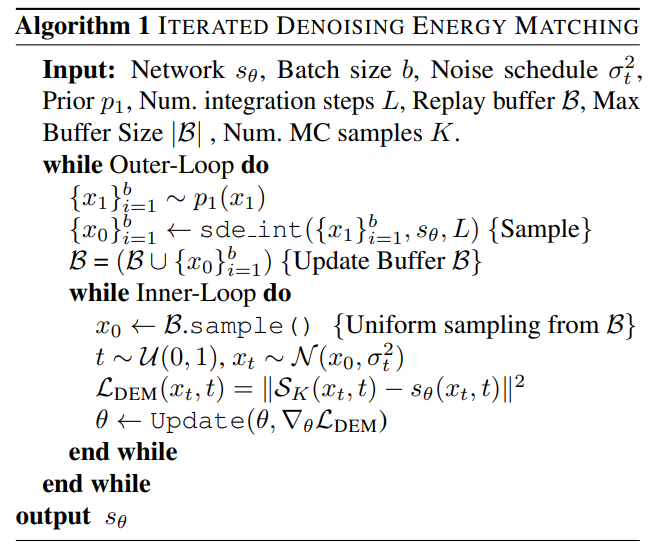

In [84]:
def training_loop(key, lr, alpha_t, g_t, integration_steps, model_apply,
                  params: any,
                  num_outer_steps: int,
                  inner_steps: int,
                  batch: int,
                  K: int):
    # initialize optimizer
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    # replay buffer
    buffer = []
    
    # time tracking
    time_start = time.time()

    for outer in range(num_outer_steps):
        # Draw x1 ~ p1 (prior). Use N(0, I)
        key, sub = jax.random.split(key)
        x1 = jax.random.normal(sub, (batch, d))

        # Integrate reverse SDE using current s_theta to get x0 proposals
        x = x1
        N = integration_steps  # integration steps
        for i in range(N):
            key, sub = jax.random.split(key)
            t = 1.0 - (i / N)  # simple schedule
            dt = 1.0 / N
            x = reverse_sde_step(sub, x, t, dt = dt, s_theta = model_apply, 
                                 params = params, alpha_t = alpha_t, g_t = g_t) # shape (batch, d)
        # Add to buffer
        for xi in np.array(x):
            buffer.append(xi)

        # Inner loop: train on buffer samples
        for inner in range(inner_steps):
            # sample batch of x0 from buffer
            idxs = np.random.randint(0, len(buffer), size=batch)
            x0_batch = jnp.array([buffer[i] for i in idxs])
            
            # sample random t ~ U(0,1) per sample
            key, sub = jax.random.split(key)
            t_batch = jax.random.uniform(sub, (batch, 1)) # shape (batch,1)
            
            # sample xt ~ N(x0, sigma_t^2)
            key, sub = jax.random.split(key)
            sigma_t = jnp.sqrt(2.0 * t_batch)  # shape (batch, 1)
            xt = x0_batch + jax.random.normal(sub, x0_batch.shape) * sigma_t # shape (batch, d)
            
            # update params with DEM loss
            key, sub = jax.random.split(key)
            energy_fn = lambda x: -log_unnormalized_target(x)
            grad_energy_fn = lambda x: -grad_log_target(x)
            params, opt_state, loss = dem_loss_and_grads(params, model_apply, sub, xt, t_batch, K,
                                                         sigma_t, energy_fn, grad_energy_fn, opt_state, optimizer)

        # optional: logging
        if outer % 10 == 0:
            #print(f'outer {outer} loss {loss}')
            time_current = time.time()
            print(f"Outer {outer:4d}/{num_outer_steps}  |  Loss: {loss:.2f}  |  Time: {time_current - time_start:.2f} s")

    return params

Sanity check S_K vs analytic score (Used for Gaussian target, but it shows that S_K is fine)

In [85]:
# # analytic score for p_t when forward is x0 + N(0, 2tI): p_t = N(mu, Sigma + 2t I)
# def analytic_score_xt(xt, t):
#     # xt (batch,d), t (batch,1)
#     if t.ndim == 1: t = t[:, None]
#     sigma2 = 2.0 * jnp.squeeze(t)
#     def one(xt_i, s2):
#         S = cov + jnp.eye(d) * s2
#         return - jnp.linalg.inv(S) @ (xt_i - mu)
#     return jax.vmap(one)(xt, sigma2)

# # sample a test batch
# key, sub = jax.random.split(key)
# B = 64
# x0_test = jax.random.multivariate_normal(sub, mu, cov, shape=(B,))
# t_test = jnp.linspace(0.01, 0.9, B)[:, None]
# key, sub = jax.random.split(key)
# xt_test = x0_test + jax.random.normal(sub, (B,d)) * jnp.sqrt(2.0 * t_test)

# SK_est = S_K(key, xt_test, t_test, K=512, energy_fn=lambda x: -log_unnormalized_target(x), grad_energy_fn=lambda x: -grad_log_target(x))
# analytic = analytic_score_xt(xt_test, t_test)
# print("SK vs analytic MSE:", float(jnp.mean((SK_est - analytic)**2)))


**Sampling**

In [86]:
def sample_from_model(key, params, model_apply, alpha_t, g_t, n_samples = 1000, T=1.0, steps=2000, x_dim=d):
    """
    Draw samples from the target distribution after training.
    """
    dt = T / steps

    # Initialize x_T from the prior p1 = N(0,I)
    key, sub = jax.random.split(key)
    x = jax.random.normal(sub, (n_samples, x_dim))

    # Reverse-time integration
    for i in range(steps):
        t = T - i * dt
        key, sub = jax.random.split(key)
        x = reverse_sde_step(sub, x, t, dt, model_apply, params, alpha_t = alpha_t, g_t = g_t)

    return x

In [87]:
key = jax.random.PRNGKey(42)
params_trained = training_loop(key, lr = 1e-3, alpha_t = 0, g_t = jnp.sqrt(2), integration_steps=100, 
                               model_apply = net.apply, params = params_net, num_outer_steps=100, 
                               inner_steps=50, batch=64, K=256)
samples = sample_from_model(key, params_trained, model_apply = net.apply, n_samples = 10000, alpha_t = 0, 
                            g_t = jnp.sqrt(2), T=1.0, steps = 2000, x_dim=d)

Outer    0/100  |  Loss: 0.77  |  Time: 3.79 s
Outer   10/100  |  Loss: 0.14  |  Time: 46.69 s
Outer   20/100  |  Loss: 0.05  |  Time: 88.48 s
Outer   30/100  |  Loss: 0.08  |  Time: 128.18 s
Outer   40/100  |  Loss: 0.03  |  Time: 173.35 s
Outer   50/100  |  Loss: 0.04  |  Time: 210.83 s
Outer   60/100  |  Loss: 0.05  |  Time: 252.91 s
Outer   70/100  |  Loss: 0.09  |  Time: 296.60 s
Outer   80/100  |  Loss: 0.04  |  Time: 337.44 s
Outer   90/100  |  Loss: 0.04  |  Time: 377.92 s


Text(0, 0.5, 'y')

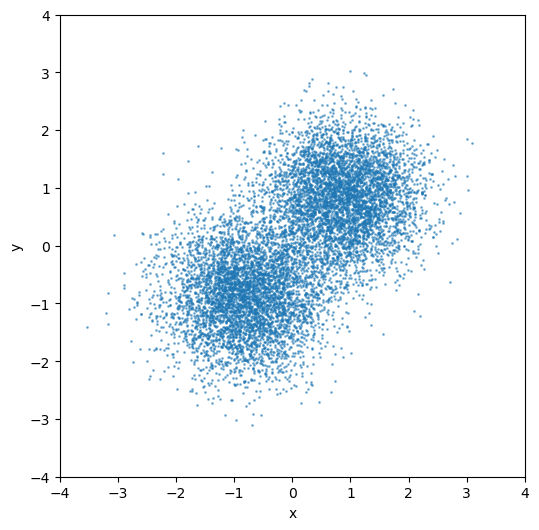

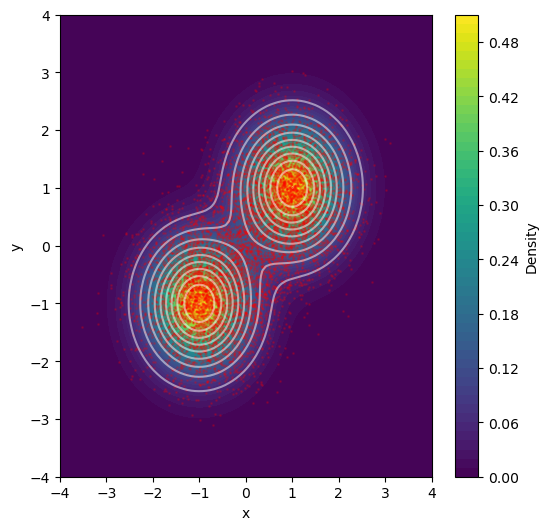

In [88]:
# do scatter plot of the final samples
plt.figure(figsize=(6,6))
plt.scatter(samples[:,0], samples[:,1], s=1, alpha=0.5)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("x")
plt.ylabel("y")

# 2d plot of log_target_batch
x = jnp.linspace(-4, 4, 100)
y = jnp.linspace(-4, 4, 100)
X, Y = jnp.meshgrid(x, y)
Z = jnp.exp(log_target_batch(jnp.stack([X.ravel(), Y.ravel()], axis=-1))).reshape(X.shape)
plt.figure(figsize=(6,6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel("x")
plt.ylabel("y")

# add level lines
plt.contour(X, Y, Z, levels=10, colors='white', alpha=0.5)


plt.scatter(samples[:,0], samples[:,1], s=1, alpha=0.2, color='red')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("x")
plt.ylabel("y")

Reverse SDE sanity check

In [ ]:
#Use S_K instead of s_theta in reverse_sde_step
def reverse_sde_step_sanity_check(rng, x, t, dt, alpha_t, g_t, energy_fn, grad_energy_fn):
    """
    Perform one step of the reverse SDE using the Euler-Maruyama method.
    """
    # x: (batch, d)
    # discrete approximate reverse SDE step (Euler-Maruyama)
    ts = jnp.full((x.shape[0], 1), t)  # shape (batch, 1)
    score = S_K(rng, x, ts, 256, energy_fn, grad_energy_fn)  # (batch, d)
    drift = alpha_t * x + (g_t**2) * score 
    noise = jax.random.normal(rng, x.shape) * jnp.sqrt(dt) * g_t
    x_next = x + drift * dt + noise
    return x_next

In [90]:
def sample_from_model_sanity_check(key, alpha_t, g_t, n_samples = 1000, T=1.0, steps=2000, x_dim=d):
    """
    Draw samples from the target distribution after training.
    """
    dt = T / steps

    # Initialize x_T from the prior p1 = N(0,I)
    key, sub = jax.random.split(key)
    x = jax.random.normal(sub, (n_samples, x_dim))
    
    # Reverse-time integration
    for i in range(steps):
        t = T - i * dt
        key, sub = jax.random.split(key)
        x = reverse_sde_step_sanity_check(sub, x, t, dt, alpha_t = alpha_t, g_t = g_t,
                                         energy_fn = lambda x: -log_unnormalized_target(x),
                                         grad_energy_fn = lambda x: -grad_log_target(x))

    return x

In [91]:
key = jax.random.PRNGKey(42)
samples_sanity_check = sample_from_model_sanity_check(key, alpha_t = 0, g_t = jnp.sqrt(2), 
                                                      n_samples = 5000, T=1.0, steps=2000, x_dim=d)

Text(0, 0.5, 'y')

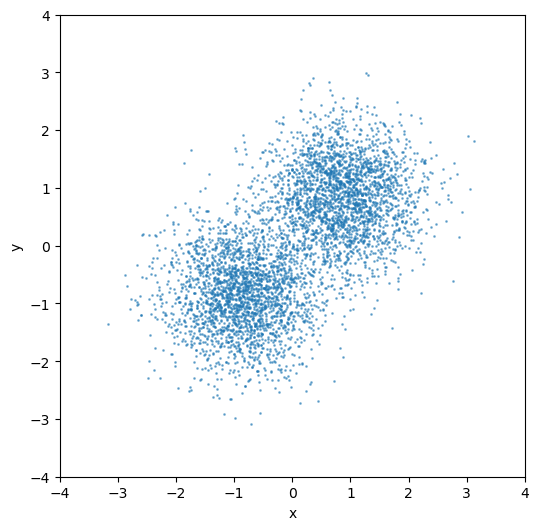

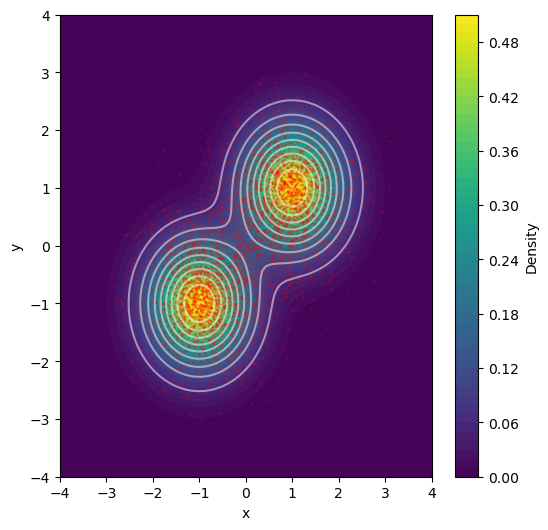

In [92]:
# do scatter plot of the final samples
plt.figure(figsize=(6,6))
plt.scatter(samples_sanity_check[:,0], samples_sanity_check[:,1], s=1, alpha=0.5)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("x")
plt.ylabel("y")

# 2d plot of log_target_batch
x = jnp.linspace(-4, 4, 100)
y = jnp.linspace(-4, 4, 100)
X, Y = jnp.meshgrid(x, y)
Z = jnp.exp(log_target_batch(jnp.stack([X.ravel(), Y.ravel()], axis=-1))).reshape(X.shape)
plt.figure(figsize=(6,6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel("x")
plt.ylabel("y")

# add level lines
plt.contour(X, Y, Z, levels=10, colors='white', alpha=0.5)


plt.scatter(samples_sanity_check[:,0], samples_sanity_check[:,1], s=1, alpha=0.2, color='red')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("x")
plt.ylabel("y")